# 드라이브 마운트

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import sys, os
sys.path.append(os.pardir)
sys.path.append('/content/drive/My Drive/dacon')
my_path = '/content/drive/My Drive/dacon/'

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from xgboost import XGBRegressor
import xgboost

# nltk packages

import nltk # 문장 토크나이저
nltk.download('all')
from nltk.corpus import names #corpus=말뭉치,이름 관련 부분 다루기 위한 객체
from nltk.corpus import stopwords # 영어 불용어 - 불용어 모아 놓은 리스트 다운로드해 제거
from nltk.tokenize import word_tokenize # 토큰화
from nltk.stem.porter import PorterStemmer # 어근 동일화 <-> 이거 말고도 "Lancaster Stemmer"
# 표제어 추출
from nltk.stem import WordNetLemmatizer
# 정규표현 처리
import re


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

In [55]:
train = pd.read_csv('/content/drive/MyDrive/dacon/train_jm.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon/test_jm.csv')

In [56]:
train_df = train.drop(columns=['ID','first_party','second_party','facts1','first_party1','second_party1'])

In [57]:
train_df.head()

,facts,issued_area,sen_len,word_len,first_party_winner,first_party_win_percent,first_party_ner,second_party_ner
0,"On June 27, 1962, Phil St. Amant, a candidate ...",others,7,201,1,0.5,PERSON,PERSON
1,Ramon Nelson was riding his bike when he suffe...,criminal,7,219,0,0.5,PERSON,PERSON
2,An Alabama state court convicted Billy Joe Mag...,criminal,8,191,1,0.5,PERSON,GPE
3,Victor Linkletter was convicted in state court...,others,3,59,0,0.5,others,others
4,"On April 24, 1953 in Selma, Alabama, an intrud...",others,9,200,1,0.5,PERSON,GPE


In [58]:
test_df = test.drop(columns=['ID','first_party','second_party','facts1','first_party1','second_party1'])

In [59]:
test_df.head()

,facts,issued_area,sen_len,word_len,first_party_win_percent,second_party_ner,first_party_ner
0,The 1984 Bail Reform Act allowed the federal c...,others,2,55,0.5,GPE,others
1,Lexecon Inc. was a defendant in a class action...,criminal,7,209,0.5,ORG,PERSON
2,"In 2002 and 2003, Fox Television Stations broa...",criminal,7,181,0.5,ORG,ORG
3,During his trial for armed robbery of a federa...,others,6,99,0.5,GPE,PERSON
4,"In 1993, a magistrate judge issued a warrant a...",others,6,154,0.5,others,PERSON


In [60]:
train_target = train_df.first_party_winner

## 수치형 변수 df

In [61]:
train_num = train_df[['sen_len','word_len','first_party_win_percent']]
test_num = test_df[['sen_len','word_len','first_party_win_percent']]

In [62]:
def categorize_probability(x):
    if x == 0:
        return 0
    elif 0 < x <= 0.33:
        return 1
    elif 0.33 < x < 0.5:
        return 2
    elif x == 0.5:
        return 3
    elif 0.5 < x < 0.57:
        return 2
    elif 0.57 <= x < 0.75:
        return 4
    elif 0.75 <= x < 1:
        return 5
    elif x == 1:
        return 6
    else:
        return -1

In [63]:
train_num.first_party_win_percent = train_num.first_party_win_percent.transform(categorize_probability)
test_num.first_party_win_percent = test_num.first_party_win_percent.transform(categorize_probability)

<ipython-input-63-a5d5f2aa3321>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_num.first_party_win_percent = train_num.first_party_win_percent.transform(categorize_probability)
<ipython-input-63-a5d5f2aa3321>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_num.first_party_win_percent = test_num.first_party_win_percent.transform(categorize_probability)


In [64]:
train_num.head()

,sen_len,word_len,first_party_win_percent
0,7,201,3
1,7,219,3
2,8,191,3
3,3,59,3
4,9,200,3


In [65]:
test_num.head()

,sen_len,word_len,first_party_win_percent
0,2,55,3
1,7,209,3
2,7,181,3
3,6,99,3
4,6,154,3


## 범주형 변수 df

In [66]:
train_cat = pd.get_dummies(data = train_df[["first_party_ner","second_party_ner","issued_area"]], drop_first=True)
test_cat = pd.get_dummies(data = test_df[["first_party_ner","second_party_ner","issued_area"]], drop_first=True)

In [67]:
train_cat.head()

,first_party_ner_ORG,first_party_ner_PERSON,first_party_ner_others,second_party_ner_ORG,second_party_ner_PERSON,second_party_ner_others,issued_area_criminal,issued_area_others
0,0,1,0,0,1,0,0,1
1,0,1,0,0,1,0,1,0
2,0,1,0,0,0,0,1,0
3,0,0,1,0,0,1,0,1
4,0,1,0,0,0,0,0,1


## facts 변수 cleaning

In [68]:
# 영어 데이터 전처리 함수
stops = set(stopwords.words('english'))
ps = nltk.stem.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()

def cleaning(str):
    replaceAll = str

    # 특수문자 및 기호 등 필요없는 문자 제거
    only_english = re.sub('[^a-zA-Z]', ' ', replaceAll)

    # 대소문자 모두 소문자로 통일
    no_capitals = only_english.lower().split()

    # 이름, 불용어(분석에 필요없는 토큰) 제거
    all_names=set(names.words())
    no_stops = [word for word in no_capitals if not word in all_names|stops]

    # 어근 추츨을 통한 텍스트 정규화 작업
    stemmer_words = [ps.stem(word) for word in no_stops]

    # 표제어 추출 Lemmatisation (convert the word into root word)
    lem_text = [lem.lemmatize(word) for word in stemmer_words]

    # back to string from list
    text = " ".join(lem_text)

    return text

In [69]:
facts1 = train_df.facts
facts2 = test_df.facts

In [70]:
facts_data = pd.concat([facts1,facts2],ignore_index=True)
facts_data

0       On June 27, 1962, Phil St. Amant, a candidate ...
1       Ramon Nelson was riding his bike when he suffe...
2       An Alabama state court convicted Billy Joe Mag...
3       Victor Linkletter was convicted in state court...
4       On April 24, 1953 in Selma, Alabama, an intrud...
                              ...                        
3713    According to Executive Order No. 12807 signed ...
3714    Section 109(a) of the Clean Air Act (CAA) requ...
3715    Linda Matteo and John Madigan created a plan f...
3716    In 1972, the North Carolina Board of Agricultu...
3717    On August 23, 1961, Dr. Paul Berheldt was stab...
Name: facts, Length: 3718, dtype: object

In [71]:
facts_data = facts_data.transform(cleaning)

In [72]:
facts_data

0       june phil st amant candid public offic made te...
1       ramon nelson ride bike suffer lethal blow back...
2       alabama state court convict billi joe magwood ...
3       victor linklett convict state court evid illeg...
4       april selma alabama intrud broke apart daughte...
                              ...                        
3713    accord execut order sign presid georg h w bush...
3714    section clean air act caa requir environment p...
3715    linda matteo john madigan creat plan util mill...
3716    north carolina board agricultur adopt regul re...
3717    august dr paul berheldt stab death kitchen hom...
Name: facts, Length: 3718, dtype: object

# 토큰화 (Tokenization)
## 단어 기반 인코딩
- Tokenizer를 이용해서 문장을 토큰화

## 텍스트를 시퀀스로 변환하기
- `texts_to_sequences()` 메서드 : 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환

In [73]:
from keras.preprocessing.text import Tokenizer
tk=Tokenizer()
tk.fit_on_texts(facts_data)

In [74]:
tseq=tk.texts_to_sequences(facts_data)
tseq # 하나하나 대입한 숫자붙여줌

[[788,
  7833,
  1183,
  4344,
  519,
  81,
  25,
  119,
  887,
  451,
  3979,
  3980,
  552,
  451,
  1183,
  4344,
  982,
  459,
  3285,
  1029,
  241,
  170,
  272,
  1068,
  310,
  3981,
  197,
  468,
  1183,
  4344,
  1879,
  5257,
  1358,
  2974,
  3979,
  3980,
  1318,
  1111,
  805,
  103,
  334,
  3981,
  197,
  1183,
  4344,
  459,
  3285,
  1358,
  842,
  50,
  1183,
  4344,
  2347,
  552,
  51,
  7,
  1,
  2,
  30,
  67,
  1358,
  295,
  1183,
  4344,
  6,
  1880,
  1358,
  2,
  14,
  1,
  552,
  1,
  12,
  430,
  81,
  1918,
  2086,
  51,
  22,
  82,
  2347,
  1183,
  4344,
  982,
  1358,
  184,
  6771,
  2212,
  161,
  4345,
  1919,
  468,
  1,
  12,
  51,
  22,
  82,
  9735,
  9736,
  3726,
  493,
  497,
  2504,
  1015,
  534,
  386,
  1340,
  2505,
  81,
  7834],
 [6772,
  1790,
  2595,
  7835,
  553,
  2596,
  4719,
  452,
  1068,
  2411,
  4346,
  42,
  3466,
  511,
  1396,
  3727,
  5258,
  1920,
  2412,
  397,
  19,
  1790,
  74,
  1790,
  645,
  438,
  1587,
  438,

# 패딩(Padding)
## 케라스 전처리 도구로 패딩하기
- 케라스의 pad_sequences() 이용
- 기본적으로 문서의 앞에 0으로 채움

In [75]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [76]:
tpad = pad_sequences(tseq)
tpad # 2차원형태의 tensor파일 형식, 즉 행렬 형식으로 변환시켜줌

array([[   0,    0,    0, ..., 2505,   81, 7834],
       [   0,    0,    0, ...,   40,  213,   18],
       [   0,    0,    0, ..., 1083, 1030,  426],
       ...,
       [   0,    0,    0, ...,    1,   36,   18],
       [   0,    0,    0, ..., 7351,  557, 1887],
       [   0,    0,    0, ...,   75,  102,  213]], dtype=int32)

In [77]:
tpad.shape

(3718, 535)

- 문서의 뒤에 0을 채우고 싶다면 인자로 padding='post'
- maxlen의 인자로 정수를 주면, 해당 정수로 모든 문서의 길이를 동일하게 함
- 길이가 maxlen보다 짧은 문서들은 0으로 패딩되고, 기존에 maxlen보다 길었다면 데이터가 손실됨

In [78]:
tpad = pad_sequences(tseq, maxlen=400, padding='post')

In [79]:
train_facts = tpad[:2478]
test_facts = tpad[2478:]

In [80]:
train_facts.shape

(2478, 400)

In [81]:
train_facts = np.asarray(train_facts)
train_facts = pd.DataFrame(data=train_facts)

test_facts = np.asarray(test_facts)
test_facts = pd.DataFrame(data=test_facts)

In [82]:
train_data = pd.concat([train_facts,train_cat,train_num,train_target],axis=1,join='inner')
test_data = pd.concat([test_facts,test_cat,test_num],axis=1,join='inner')

In [83]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,first_party_ner_others,second_party_ner_ORG,second_party_ner_PERSON,second_party_ner_others,issued_area_criminal,issued_area_others,sen_len,word_len,first_party_win_percent,first_party_winner
0,788,7833,1183,4344,519,81,25,119,887,451,...,0,0,1,0,0,1,7,201,3,1
1,6772,1790,2595,7835,553,2596,4719,452,1068,2411,...,0,0,1,0,1,0,7,219,3,0
2,319,4,1,19,2800,2413,4348,85,24,74,...,0,0,0,0,1,0,8,191,3,1
3,4720,7836,19,4,1,40,304,169,48,245,...,1,0,0,1,0,1,3,59,3,0
4,707,7837,319,5866,2507,649,973,126,1792,973,...,0,0,0,0,0,1,9,200,3,1


# Define Model & Train

In [84]:
from keras.models import Sequential
from keras.layers import Embedding,SimpleRNN,Dense
from keras.layers import Bidirectional,Dropout,GRU,LSTM
from tensorflow.keras.layers import BatchNormalization
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Cross Validation 이용해서 Train dataset을 Train / Validation dataset으로 분리

In [85]:
X_train = train_data.drop(columns='first_party_winner')
y_train = train_data['first_party_winner']

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2, stratify=y_train,
                                                  random_state=42)

## LSTM
### model 정의

In [87]:
model = Sequential()
model.add(Embedding(len(tk.word_index)+1, 500, input_length=411))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 411, 500)          6236500   
                                                                 
 lstm_3 (LSTM)               (None, 64)                144640    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,381,205
Trainable params: 6,381,205
Non-trainable params: 0
_________________________________________________________________


In [88]:
# 검증 데이터 손실(val_loss)이 증가하면 조기 종료
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

# 훈련 과정에서 검증 데이터의 정확도가 가장 높은 모델 저장
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [89]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## model 학습
### 콜백함수 : early stopping. model checkpoint 적용한 경우

In [ ]:
history=model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=[X_val, y_val],
                    callbacks=[es, mc])

### 콜백함수 적용하지 않은 경우

In [91]:
history=model.fit(X_train, y_train,
           batch_size=32,
           epochs=20,
           validation_data=[X_val, y_val]
           )

Epoch 1/20
62/62 [==============================] - 5s 87ms/step - loss: 0.6200 - accuracy: 0.6640 - val_loss: 0.6267 - val_accuracy: 0.6613
Epoch 2/20
62/62 [==============================] - 5s 81ms/step - loss: 0.6058 - accuracy: 0.6771 - val_loss: 0.6310 - val_accuracy: 0.6492
Epoch 3/20
62/62 [==============================] - 3s 49ms/step - loss: 0.5929 - accuracy: 0.6892 - val_loss: 0.6402 - val_accuracy: 0.6452
Epoch 4/20
62/62 [==============================] - 3s 55ms/step - loss: 0.5766 - accuracy: 0.7013 - val_loss: 0.6564 - val_accuracy: 0.6512
Epoch 5/20
62/62 [==============================] - 2s 30ms/step - loss: 0.5651 - accuracy: 0.7079 - val_loss: 0.6699 - val_accuracy: 0.5847
Epoch 6/20
62/62 [==============================] - 4s 58ms/step - loss: 0.5602 - accuracy: 0.7114 - val_loss: 0.6789 - val_accuracy: 0.6048
Epoch 7/20
62/62 [==============================] - 2s 32ms/step - loss: 0.5514 - accuracy: 0.7144 - val_loss: 0.6883 - val_accuracy: 0.5927
Epoch 8/20
62

### epoch에 따른 loss, accuracy plot 그리기

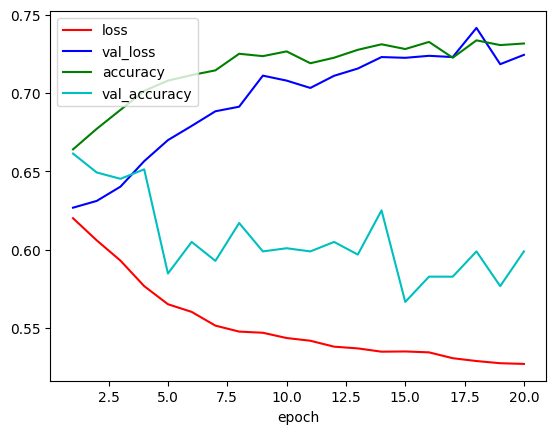

In [92]:
# 에포크마다 변화하는 훈련 데이터와 검증 데이터(테스트 데이터)의 손실 그리기

epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'], c='r')
plt.plot(epochs, history.history['val_loss'], c='b')
plt.plot(epochs, history.history['accuracy'], c='g')
plt.plot(epochs, history.history['val_accuracy'], c='c')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'], loc='upper left')
plt.show()

## Bidirectional LSTM
### model 정의

In [ ]:
bi_lstm_model = Sequential()
bi_lstm_model.add(Embedding(len(tk.word_index)+1, 500, input_length=411))
bi_lstm_model.add(Bidirectional(LSTM(64)))
bi_lstm_model.add(Dropout(0.2))
bi_lstm_model.add(Dense(1, activation='sigmoid'))

bi_lstm_model.summary()

In [ ]:
bi_lstm_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### model 학습

In [ ]:
bi_history = bi_lstm_model.fit(X_train, y_train,
                                batch_size=32,
                                epochs=50,
                                validation_data=[X_val, y_val],
                                callbacks=[es, mc])

## model predict

In [93]:
result = model.predict(test_data)

39/39 [==============================] - 1s 9ms/step


In [94]:
result

array([[0.5064657 ],
       [0.62135404],
       [0.85499734],
       ...,
       [0.21467677],
       [0.78692204],
       [0.10958497]], dtype=float32)

### 결과 라벨링
model이 predict한 결과,
- 확률이 0.5 이상이면 1 (fisrt_party가 승소)
- 확률이 0.5 미만이면 0

In [95]:
result_label = []
for res in result:
  if(res >= 0.5):
    result_label.append(1)
  else:
    result_label.append(0)

In [96]:
result_label = np.array(result_label)

In [99]:
submit = pd.read_csv("/content/drive/MyDrive/dacon/sample_submission.csv")

submit['first_party_winner'] = result_label
submit.to_csv('./LSTM_no_es.csv', index=False)
print('Done')

Done
